In [79]:
# 1) Business Question
# 2) Data Collection
# 3) Preprocessing
# 4) Model(s) Creation
# 5) Model Evaluation and Comparison
# 6) Conclusion and Future Improvements
#https://www.kaggle.com/c/home-credit-default-risk/data?select=installments_payments.csv
import pandas as pd
import numpy as np
import math
from datetime import datetime
import scipy
from scipy import stats
#Graph
import seaborn as sns
import matplotlib.pyplot as plt
#sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from  sklearn.impute import SimpleImputer   
from imblearn.over_sampling import SMOTE

from matplotlib import pyplot

pd.set_option('display.max_rows', 30)

In [87]:
sns.set_color_codes("pastel")
#s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
s = sns.barplot(x = df['CREDIT_TYPE'],data=df)

KeyError: 'CREDIT_TYPE'

In [70]:
#-----------------------------------------------------Data Preprocessing-----------------------------------------------------#
##                                      (Drop columns with missing data & 4% correlation)
# SMOTE                                 (Imbalanced data: score 15 points more)
# Outliner                              (no difference> does not affect the result , by removing 3% standard deviation)
# Mean on numbers; Median on labels     (Median performs little worse)  diff show outliners
# drop_rate = 1                         (Drop nothing to performs little better))
# Standardization                       (MinMaxScaler performs little worse))
# Regression, XGboost, Random Forest    (Score 68)

#Load DataFrame
df = pd.read_csv("./data/application_train.csv" ) #  index_col=0  ID which is used for mapping other excel files goes to index column
df_bureau = pd.read_csv("./data/bureau.csv" ) 
print('original shape: ' , df.shape)

#drop ID
df.drop(columns=['SK_ID_CURR','DAYS_BIRTH'], inplace=True)

#Step :    #--------------------------------------------------------------->>>categorical columns<<<   missing values
drop_rate = 1 #0.3 mean the data with 70% more  
drop_col_lst_1 = []
for col in df.columns:
    if (df[col].isna().sum() / df.shape[0] <= drop_rate )&(type(df[col][0])==str):
        df[col].fillna(  df[col].mode()[0]  ,inplace=True)  #   >>>categorical columns<<<   Minor missing values
    elif (df[col].isna().sum() / df.shape[0] > drop_rate )&(type(df[col][0])==str):
        drop_col_lst_1.append(col)                          #   >>>categorical columns<<<   Huge missing values
df.drop(columns=drop_col_lst_1 , inplace=True)

#Step :    #--------------------------------------------------------------->>>Numerical columns<<<   missing values
drop_col_lst_2 = []
from sklearn.impute import SimpleImputer
for col in df.columns:
    if (df[col].isna().sum() / df.shape[0] > drop_rate )&((type(df[col][0])==np.int64)|(type(df[col][0])==np.float64)):
        drop_col_lst_2.append(col) 
print('Columns that is dropped due to missing values: \n',drop_col_lst_1,drop_col_lst_2)
df.drop(columns=drop_col_lst_2 , inplace=True)
#   Replace missing values with mean
df[list(df.select_dtypes(include=["int64","float64"]).columns)]     =       pd.DataFrame(   SimpleImputer(missing_values=np.NaN, strategy='mean').fit_transform(  df[list(df.select_dtypes(include=["int64","float64"]).columns)].values),index = df.index,columns=  list(df.select_dtypes(include=["int64","float64"]).columns) )   

#Step :    #---------------------------------------------------------------To drop columns with low correlation
# drop_col_lst_3 = []
# for col in df.columns:
#     try:
#         if (df_corr['Abs_correlation'][col] <=0.02):    #0.032131 > top 30
#             drop_col_lst_3.append(col) 
#     except:
#         continue
# df.drop(columns=drop_col_lst_3 , inplace=True)
# print('Columns that is dropped due to their low correlation: \n',drop_col_lst_3)

#Step :    #---------------------------------------------------------------Remove outliners
print('df shape before outliners:' , df.shape)
df = df[(np.abs( df[df.drop(columns='TARGET').select_dtypes(include=[np.number]).columns].apply(stats.zscore))       < float(3)).all(axis=1)]
print('df shape after outliners:' , df.shape)

#Step :    #---------------------------------------------------------------fix unbalanced dataset    
df.drop(df.query('TARGET == 0').sample(((df.query('TARGET == 0').shape[0])-1*(df.query('TARGET == 1').shape[0]))).index,inplace=True)  #Downscale the data with '0'
print(df.TARGET.value_counts())
#Step :    #---------------------------------------------------------------Standardization & Labelling

X = df.drop(columns=['TARGET'])
y = df[['TARGET']]

# Standardization (0 mean, 1 stdev) https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
# X[list(X.select_dtypes(include=["int64","float64"]).columns)] = pd.DataFrame(   StandardScaler().fit_transform(X[list(X.select_dtypes(include=["int64","float64"]).columns)].values), index = X.index, columns = list(X[list(X.select_dtypes(include=["int64","float64"]).columns)].columns))   

#MinMaxScaler
# X[list(X.select_dtypes(include=["int64","float64"]).columns)] = pd.DataFrame(   MinMaxScaler(feature_range=(0, 1)).fit_transform(X[list(X.select_dtypes(include=["int64","float64"]).columns)].values), index = X.index, columns = list(X[list(X.select_dtypes(include=["int64","float64"]).columns)].columns)) 

#Step :    #---------------------------------------------------------------#One Hot Encoder  
X= pd.get_dummies(X, drop_first=True)       

print('X.shape = ' , X.shape)
y.head()
X.head()

original shape:  (307511, 122)
Columns that is dropped due to missing values: 
 [] []
df shape before outliners: (307511, 120)
df shape after outliners: (151404, 120)
1.0    12481
0.0    12481
Name: TARGET, dtype: int64
X.shape =  (24962, 223)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
9,0.0,135000.0,405000.0,20250.0,405000.0,0.019689,-2019.0,-14437.0,-3992.0,12.061091,...,0,0,0,0,0,0,1,0,0,0
13,1.0,225000.0,918468.0,28966.5,697500.0,0.016612,-3028.0,-643.0,-4911.0,23.000000,...,0,0,0,0,0,0,1,0,0,0
40,0.0,202500.0,1193580.0,35028.0,855000.0,0.025164,-1262.0,-1182.0,-1029.0,12.061091,...,0,0,0,0,0,0,0,1,0,0
42,0.0,135000.0,288873.0,16258.5,238500.0,0.007305,-3597.0,-45.0,-4409.0,12.061091,...,0,0,0,0,0,0,1,0,0,0
45,1.0,90000.0,180000.0,9000.0,180000.0,0.009334,-895.0,-6591.0,-642.0,12.061091,...,0,0,0,0,0,0,1,0,0,0


In [71]:
#   RamdonForest                       #---------------------Modelling---------------------#
#No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)       #

rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)  #, max_leaf_nodes=16
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

confusion_matrix:    
 [[1744  753]
 [ 838 1658]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.68      0.70      0.69      2497
         1.0       0.69      0.66      0.68      2496

    accuracy                           0.68      4993
   macro avg       0.68      0.68      0.68      4993
weighted avg       0.68      0.68      0.68      4993

accuracy_score:  
 0.6813538954536351  ; with data size of  (19969, 223)


In [56]:
#XGboost
print('-------XGboost-------')
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size =0.2, random_state=42, stratify = y)
#SMOTE: too many False Negative
print(X.shape)

model =XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

-------XGboost-------
(24962, 224)
[08:25:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion_matrix:    
 [[1636  861]
 [ 824 1672]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.67      0.66      0.66      2497
         1.0       0.66      0.67      0.66      2496

    accuracy                           0.66      4993
   macro avg       0.66      0.66      0.66      4993
weighted avg       0.66      0.66      0.66      4993

accuracy_score:  
 0.6625275385539756  ; with data size of  (19969, 224)


-------Regression model-------
X_train shape is:   (19969, 223)
confusion_matrix:    
 [[1542  955]
 [1101 1395]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.58      0.62      0.60      2497
         1.0       0.59      0.56      0.58      2496

    accuracy                           0.59      4993
   macro avg       0.59      0.59      0.59      4993
weighted avg       0.59      0.59      0.59      4993

accuracy_score:  
 0.5882235129180853  ; with data size of  (19969, 223)
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00002
Feature: 4, Score: -0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00002
Feature: 8, Score: 0.00001
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Featu

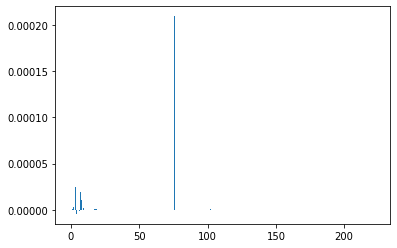

In [82]:
#Regression model       #---------------------Modelling---------------------#
print('-------Regression model-------')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
print('X_train shape is:  ', X_train.shape)
# print('Sample size before SMOTE method: ' , X_train.shape)    
# X_train,y_train = SMOTE(random_state = 42, k_neighbors = 3).fit_resample(X_train,y_train)     #SMOTE: too many False Negative
# print('Sample size after SMOTE method: ' , X_train.shape)
#Oversampling the data     ## https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5

logmodel = LogisticRegression()     # Create instance (i.e. object) of LogisticRegression
logmodel.fit(X_train, y_train)      # Fit the model using the training data
y_pred = logmodel.predict(X_test)   #Predicting the target for test data

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

# get importance
importance = logmodel.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)     #range(len(importance))
pyplot.show()

In [78]:
logmodel.coef_[0]

array([ 7.39897206e-08,  4.65479071e-07,  3.29417174e-06,  2.42150890e-05,
       -4.48239987e-06, -2.12958038e-10, -9.66599942e-07,  1.90759596e-05,
        1.10988042e-05,  1.55581147e-06,  7.82155127e-08,  8.06057081e-08,
        1.17834308e-07,  7.82155127e-08, -3.26833900e-10,  0.00000000e+00,
        1.52563151e-07,  3.23020773e-07,  3.34918264e-07,  5.68591797e-07,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.70729535e-08,  9.70729535e-08, -4.30521700e-08, -1.85517713e-07,
       -1.56814274e-07,  6.25126502e-09,  6.64775830e-09,  7.56627301e-08,
        5.53255362e-08,  3.03991226e-09,  2.33304489e-09,  8.84902033e-09,
        8.65088418e-09,  1.49586882e-08,  3.08807396e-09,  6.71015997e-09,
        3.62595089e-09,  9.32599182e-10,  3.48775231e-09,  5.87659415e-09,
        6.56255261e-09,  7.55235554e-08,  5.58976487e-08,  2.89876722e-09,
        1.95772344e-09,  8.44493863e-09,  8.13478116e-09,  1.42999665e-08,
        3.26388122e-09,  

In [58]:
#   KNN                                    #---------------------Modelling---------------------#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)       #
#SMOTE: too slow , run like 1 hour for data set with ~300k size

knn = KNeighborsClassifier(n_neighbors=5)   #Make an object
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

#Classification Metrics
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative''')
print('classification_report:   \n',    classification_report(y_test, y_pred))
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)

confusion_matrix:    
 [[1346 1151]
 [1037 1459]]

True positive      False positive
False Negative      True negative
classification_report:   
               precision    recall  f1-score   support

         0.0       0.56      0.54      0.55      2497
         1.0       0.56      0.58      0.57      2496

    accuracy                           0.56      4993
   macro avg       0.56      0.56      0.56      4993
weighted avg       0.56      0.56      0.56      4993

accuracy_score:  
 0.5617865011015422  ; with data size of  (19969, 224)


In [63]:
#   RamdonForest                       #---------------------Modelling---------------------#
#No change when we remove columns with relatively low correlation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)       #

# print('Sample size before SMOTE method: ' , X_train.shape)
# X_train,y_train = SMOTE(random_state = 42).fit_resample(X_train,y_train)
# print('Sample size after SMOTE method: ' , X_train.shape)

#---------------------Modelling---------------------#  RamdonForest > unlimitted depth and leaf
rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)  #, max_leaf_nodes=16
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

# #---------------------Modelling---------------------#  Multiclass classification with under-sampling
# print(type(y_train))
# print('Training target statistics: {}'.format(Counter(y_train)))
# print('Testing target statistics: {}'.format(Counter(y_test)))
# # Create a pipeline
# pipeline = make_pipeline(NearMiss(version=2),
#                          LinearSVC(random_state=42))
# pipeline.fit(X_train, y_train)

#---------------------Modelling---------------------#  AdaBoost#;   RamdonForest > unlimitted depth and leaf
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier

# ada_clf = AdaBoostClassifier(
#     #DecisionTreeClassifier(max_depth=2), n_estimators=200,learning_rate=0.05, random_state=42)
#     DecisionTreeClassifier(), n_estimators=200,learning_rate=0.05, random_state=42)
# ada_clf.fit(X_train, y_train)
# y_pred = ada_clf.predict(X_test)

# # #5.1 - Hyperparameter Tuning (Max Depth)#---------------------Modelling---------------------#  Find Max depth
# # parameters = {'max_depth' : list(range(1,11))}
# # from sklearn.model_selection import GridSearchCV
# # search = GridSearchCV(DecisionTreeClassifier(),param_grid=parameters,cv=10)
# # search.fit(X_train,y_train)
# # print('search.best_score_:' , search.best_score_)
# # print('search.best_params_:', search.best_params_)

# # #5.2 - Hyperparameter Tuning (Max Depth)#---------------------Modelling---------------------#  List all score of diff depth
# # # List of values to try for max_depth:
# # max_depth_range = list(range(1, 11))
# # # List to store the accuracy for each value of max_depth:
# # accuracy = []
# # for depth in max_depth_range:
    
# #     clf = DecisionTreeClassifier(max_depth = depth, random_state=0)
# #     clf.fit(X_train, y_train)
# #     score = clf.score(X_test, y_test)
# #     accuracy.append(score)

#Step 6:    Classification Metrics        #---------------------Score---------------------#
from sklearn.metrics import confusion_matrix
print('confusion_matrix:    \n',    confusion_matrix(y_test, y_pred))
print('''
True positive      False positive
False Negative      True negative
''')
from sklearn.metrics import classification_report
print('classification_report:   \n',    classification_report(y_test, y_pred))
from sklearn.metrics import accuracy_score
print('accuracy_score:  \n',    accuracy_score(y_test, y_pred) , ' ; with data size of ' , X_train.shape)     #Same as logmodel.score(X_test,y_test)
#--Other models--

confusion_matrix:    
 [[2427 1104]
 [1203 2327]]

True positive      False positive
False Negative      True negative

classification_report:   
               precision    recall  f1-score   support

         0.0       0.67      0.69      0.68      3531
         1.0       0.68      0.66      0.67      3530

    accuracy                           0.67      7061
   macro avg       0.67      0.67      0.67      7061
weighted avg       0.67      0.67      0.67      7061

accuracy_score:  
 0.6732757399801728  ; with data size of  (28243, 171)


In [15]:
# from imblearn.ensemble import BalancedRandomForestClassifier
# from sklearn.datasets import make_classification

# X, y = make_classification(n_samples=1000, n_classes=3,
#                            n_informative=4, weights=[0.2, 0.3, 0.5],
#                            random_state=0)
                        
# clf = BalancedRandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X, y)  
# print(pd.DataFrame(X))
# print('feature_importances_' , clf.feature_importances_)  
# print(clf.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))
# X.shape

In [18]:
# #https://imbalanced-learn.org/stable/auto_examples/applications/plot_multi_class_under_sampling.html
# # Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# # License: MIT

# from collections import Counter

# from sklearn.datasets import load_iris
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import train_test_split

# from imblearn.datasets import make_imbalance
# from imblearn.under_sampling import NearMiss
# from imblearn.pipeline import make_pipeline
# from imblearn.metrics import classification_report_imbalanced

# print(__doc__)

# RANDOM_STATE = 42

# # Create a folder to fetch the dataset
# iris = load_iris()
# X, y = make_imbalance(iris.data, iris.target,
#                       sampling_strategy={0: 25, 1: 50, 2: 50},
#                       random_state=RANDOM_STATE)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=RANDOM_STATE)

# print('Training target statistics: {}'.format(Counter(y_train)))
# print('Testing target statistics: {}'.format(Counter(y_test)))

# # Create a pipeline
# pipeline = make_pipeline(NearMiss(version=2),
#                          LinearSVC(random_state=RANDOM_STATE))
# pipeline.fit(X_train, y_train)

# # Classify and report the results
# print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

In [19]:
##LGBMClassifier

In [36]:
#Correlation preset ------------ part 1
df = pd.read_csv("./data/application_train.csv" )
df_corr = pd.DataFrame( df.corr()['TARGET'])
df_corr['MissingValue'] = [df[list(df_corr.index)[x]].isna().sum() for x in range(len(pd.DataFrame(df_corr)['TARGET']))]
#df_corr = df_corr[df_corr['MissingValue']>30000].sort_values(by=['TARGET'])
df_corr['Abs_correlation'] = abs(df_corr['TARGET'])
df_corr.sort_values(by=['Abs_correlation'],ascending=False,inplace=True)
print(df_corr)
print(len(list(df_corr.index)))
"','".join(list(df_corr.index))

# #Correlation preset ------------ part 2

# pd.set_option('display.max_rows', None)

# #Keep certain percent
# df_corr_Work = df_corr[(df_corr['TARGET']>=-0.04)&(df_corr['TARGET']<=0.04)]
# print('shape: ',df_corr_Work.shape)
# print(df_corr_Work)
# print(list(df_corr_Work.index))

                    TARGET  MissingValue  Abs_correlation
TARGET            1.000000             0         1.000000
EXT_SOURCE_3     -0.178919         60965         0.178919
EXT_SOURCE_2     -0.160472           660         0.160472
EXT_SOURCE_1     -0.155317        173378         0.155317
DAYS_BIRTH        0.078239             0         0.078239
...                    ...           ...              ...
FLAG_DOCUMENT_12 -0.000756             0         0.000756
FLAG_MOBIL        0.000534             0         0.000534
FLAG_CONT_MOBILE  0.000370             0         0.000370
FLAG_DOCUMENT_5  -0.000316             0         0.000316
FLAG_DOCUMENT_20  0.000215             0         0.000215

[106 rows x 3 columns]
106


"TARGET','EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','REG_CITY_NOT_WORK_CITY','FLAG_EMP_PHONE','DAYS_EMPLOYED','REG_CITY_NOT_LIVE_CITY','FLAG_DOCUMENT_3','FLOORSMAX_AVG','FLOORSMAX_MEDI','FLOORSMAX_MODE','DAYS_REGISTRATION','AMT_GOODS_PRICE','OWN_CAR_AGE','REGION_POPULATION_RELATIVE','ELEVATORS_AVG','ELEVATORS_MEDI','FLOORSMIN_AVG','FLOORSMIN_MEDI','LIVINGAREA_AVG','LIVINGAREA_MEDI','FLOORSMIN_MODE','TOTALAREA_MODE','LIVE_CITY_NOT_WORK_CITY','DEF_30_CNT_SOCIAL_CIRCLE','ELEVATORS_MODE','DEF_60_CNT_SOCIAL_CIRCLE','LIVINGAREA_MODE','AMT_CREDIT','APARTMENTS_AVG','APARTMENTS_MEDI','FLAG_DOCUMENT_6','FLAG_WORK_PHONE','APARTMENTS_MODE','LIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_MEDI','HOUR_APPR_PROCESS_START','FLAG_PHONE','LIVINGAPARTMENTS_MODE','BASEMENTAREA_AVG','YEARS_BUILD_MEDI','YEARS_BUILD_AVG','BASEMENTAREA_MEDI','YEARS_BUILD_MODE','BASEMENTAREA_MODE','AMT_REQ_CREDIT_BUREAU_YEAR'

In [37]:
df_corr_top20 = df_corr[(df_corr['Abs_correlation']>=0.034199)]
df_corr_top20.drop('TARGET',inplace=True)
print(df_corr_top20)

df_corr_top20.columns=['Correlation','Count_MissingValues','Abs_correlation']
df_corr_top20

                               TARGET  MissingValue  Abs_correlation
EXT_SOURCE_3                -0.178919         60965         0.178919
EXT_SOURCE_2                -0.160472           660         0.160472
EXT_SOURCE_1                -0.155317        173378         0.155317
DAYS_BIRTH                   0.078239             0         0.078239
REGION_RATING_CLIENT_W_CITY  0.060893             0         0.060893
REGION_RATING_CLIENT         0.058899             0         0.058899
DAYS_LAST_PHONE_CHANGE       0.055218             1         0.055218
DAYS_ID_PUBLISH              0.051457             0         0.051457
REG_CITY_NOT_WORK_CITY       0.050994             0         0.050994
FLAG_EMP_PHONE               0.045982             0         0.045982
DAYS_EMPLOYED               -0.044932             0         0.044932
REG_CITY_NOT_LIVE_CITY       0.044395             0         0.044395
FLAG_DOCUMENT_3              0.044346             0         0.044346
FLOORSMAX_AVG               -0.044

,Correlation,Count_MissingValues,Abs_correlation
EXT_SOURCE_3,-0.178919,60965,0.178919
EXT_SOURCE_2,-0.160472,660,0.160472
EXT_SOURCE_1,-0.155317,173378,0.155317
DAYS_BIRTH,0.078239,0,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893,0,0.060893
REGION_RATING_CLIENT,0.058899,0,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218,1,0.055218
DAYS_ID_PUBLISH,0.051457,0,0.051457
REG_CITY_NOT_WORK_CITY,0.050994,0,0.050994
FLAG_EMP_PHONE,0.045982,0,0.045982
